# barplots of mean relative loss 

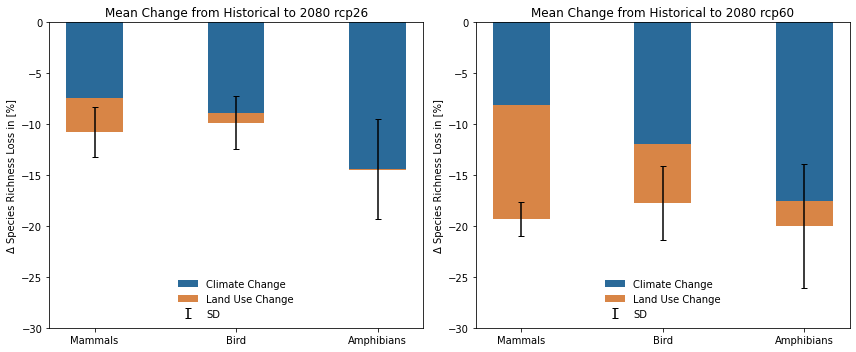

<Figure size 432x288 with 0 Axes>

In [1]:
# relative loss in species richness globally 
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26","rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}

    for sdm in sdms:
        mean_newvalue_change[scenario][sdm] = {}
        mean_sum_bin_change[scenario][sdm] = {}
        mean_land_use_change[scenario][sdm] = {}

        for gcm in gcms:
            mean_newvalue_change[scenario][sdm][gcm] = {}
            mean_sum_bin_change[scenario][sdm][gcm] = {}
            mean_land_use_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

                                # Avoid division by zero
                            # Handle missing values (if necessary)
                # Calculate the difference
                difference = newvalue_future_sum_taxa - newvalue_hist_sum_taxa

                # Identify where there is a loss (future < historical)
                loss_mask = difference < 0

                # Non-zero mask for the historical data to avoid division by zero
                non_zero_mask = newvalue_hist_sum_taxa != 0

                # Calculate relative loss only for loss cases
                # Use xr.where to apply the loss_mask and non_zero_mask
                climate_change = xr.where(loss_mask & non_zero_mask, difference / newvalue_hist_sum_taxa * 100, 0)

                # Repeat similar steps for sum_bin data


                
                                # Calculate the difference
                difference = sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa

                # Identify where there is a loss (future < historical)
                loss_mask = difference < 0

                # Non-zero mask for the historical data to avoid division by zero
                non_zero_mask = sum_bin_hist_sum_taxa != 0

                # Calculate relative loss only for loss cases
                # Use xr.where to apply the loss_mask and non_zero_mask
                climate_land_change = xr.where(loss_mask & non_zero_mask, difference / sum_bin_hist_sum_taxa * 100, 0)

                # Repeat similar steps for sum_bin data


                land_use_change = climate_land_change - climate_change

                climate_land_change_loss = climate_land_change.where(climate_land_change < 0)
                climate_change_loss = climate_change.where((climate_land_change < 0) & (climate_change < 0))


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][sdm][gcm][taxa] = climate_change_loss
                mean_sum_bin_change[scenario][sdm][gcm][taxa] = climate_land_change_loss
                mean_land_use_change[scenario][sdm][gcm][taxa] = land_use_change

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]

       # mean_climate_change = np.median([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])
       # mean_land_use_change2 = np.median([np.mean(mean_sum_bin_change[scenario][sdm][gcm][taxa] - mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        #std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])
        
        
        climate_change_data = np.concatenate([mean_newvalue_change[scenario][sdm][gcm][taxa].values.flatten() for sdm in sdms for gcm in gcms])
        land_use_change_data = np.concatenate([mean_sum_bin_change[scenario][sdm][gcm][taxa].values.flatten() for sdm in sdms for gcm in gcms])

        # Calculate the median for the concatenated data
        mean_climate_change = np.nanmean(climate_change_data)
        mean_land_use_change2 = np.nanmean(land_use_change_data) -mean_climate_change
        

        std_dev_climate_change = np.std([np.nanmean(mean_newvalue_change[scenario][sdm][gcm][taxa].values)for sdm in sdms for gcm in gcms])


        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='SD')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land Use Change', 'SD'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:
    ax.set_ylim(top=0, bottom=-30)
    #ax.set_yticks(np.arange(0, -26, -5))
    # Set plot details
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Loss in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()
plt.savefig(f"/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Fig_4_{year_indices[time_ind]}_loss_rel.png")
    #

In [102]:

regionlist = ['West, Central, East & South Africa']



    # ... [code for loading and processing data] ...
for region in regionlist:
    
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')


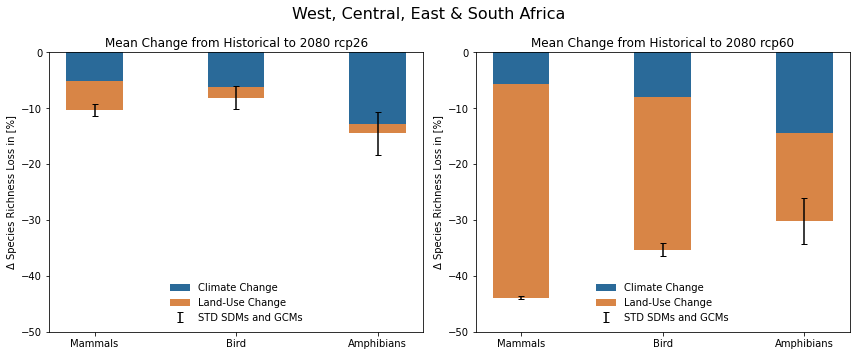

<Figure size 432x288 with 0 Axes>

In [66]:
# relative loss in species richness sub-saharan africa mean
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}

    for sdm in sdms:
        mean_newvalue_change[scenario][sdm] = {}
        mean_sum_bin_change[scenario][sdm] = {}
        mean_land_use_change[scenario][sdm] = {}

        for gcm in gcms:
            mean_newvalue_change[scenario][sdm][gcm] = {}
            mean_sum_bin_change[scenario][sdm][gcm] = {}
            mean_land_use_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

                            # Handle missing values (if necessary)
                da1_filled = newvalue_future_sum_taxa.fillna(0)  # Or choose another method to handle NaNs
                da2_filled = newvalue_hist_sum_taxa.fillna(0)  # Or choose another method to handle NaNs

                # Calculate the difference
                difference = da1_filled - da2_filled

                # Identify where there is a loss (da2 < da1)
                loss_mask = difference < 0

                # Calculate relative loss only for loss cases
                relative_loss = difference.where(loss_mask) / da2_filled.where(loss_mask)

                # Handle divisions by zero (if necessary)
                climate_change = relative_loss.fillna(0) * 100  # Replace NaNs from division by zero with 0
                
                
                da1_filled = sum_bin_future_sum_taxa.fillna(0)  # Or choose another method to handle NaNs
                da2_filled = sum_bin_hist_sum_taxa.fillna(0)  # Or choose another method to handle NaNs

                # Calculate the difference
                difference = da1_filled - da2_filled

                # Identify where there is a loss (da2 < da1)
                loss_mask = difference < 0

                # Calculate relative loss only for loss cases
                relative_loss = difference.where(loss_mask) / da2_filled.where(loss_mask)

                # Handle divisions by zero (if necessary)
                climate_land_change = relative_loss.fillna(0) * 100 # Replace NaNs from division by zero with 0


                # Now handle NaN values or negative values as needed
                #climate_land_change_loss = xr.where(climate_land_change < 0, climate_land_change, np.nan)
                #climate_change_loss = xr.where((climate_land_change < 0) & (climate_change < 0), climate_change, np.nan)
                
                climate_land_change_loss = climate_land_change.where(climate_land_change<0).where(oceania_mask_renamed==1)
                climate_change_loss = climate_change.where(climate_change < 0).where(oceania_mask_renamed==1)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][sdm][gcm][taxa] = climate_change_loss
                mean_sum_bin_change[scenario][sdm][gcm][taxa] = climate_land_change_loss

                
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]

        mean_climate_change = np.nanmean([np.nanmean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])
        mean_land_use_change2 = np.nanmean([np.nanmean(mean_sum_bin_change[scenario][sdm][gcm][taxa] - mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        std_dev_climate_change = np.std([np.nanmean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:
    ax.set_ylim(top=0, bottom=-50)
    #ax.set_yticks(np.arange(0, -26, -5))
    # Set plot details
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Loss in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')
fig.suptitle('West, Central, East & South Africa', fontsize=16)
plt.tight_layout()
plt.show()
plt.savefig(f"/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Fig_4_{year_indices[time_ind]}_loss_rel.png")
    #

# barplots of mean relative gains 

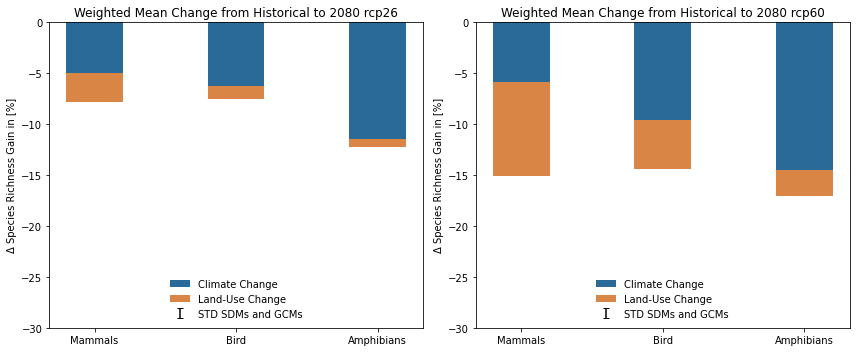

In [149]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants
R = 6371 * 1e3  # Earth's radius in meters
deg_to_rad = np.pi / 180.0  # Conversion factor from degrees to radians

# Extract lat and lon from your DataArray
lat = newvalue_future_sum_taxa.coords['lat']
lon = newvalue_future_sum_taxa.coords['lon']

# Calculate the area for each latitudinal stripe
# Assuming the latitude and longitude are evenly spaced
lat_edges = np.linspace(90, -90, len(lat) + 1)
lat_rad = lat_edges * deg_to_rad
area_lat = R**2 * np.diff(np.sin(lat_rad))

# The area for each grid cell
cell_area = np.outer(area_lat, np.ones(len(lon)))
# Extract raw coordinate values
lat_values = lat.values
lon_values = lon.values

# Create the xarray DataArray for cell_area using these raw values
cell_area_xr = xr.DataArray(cell_area, coords=[('lat', lat_values), ('lon', lon_values)])



# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

             # Calculate the difference
                difference = newvalue_future_sum_taxa - newvalue_hist_sum_taxa

                # Identify where there is a loss (future < historical)
                loss_mask = difference < 0

                # Non-zero mask for the historical data to avoid division by zero
                non_zero_mask = newvalue_hist_sum_taxa != 0

                # Calculate relative loss only for loss cases
                # Use xr.where to apply the loss_mask and non_zero_mask
                climate_change = xr.where(loss_mask & non_zero_mask, difference / newvalue_hist_sum_taxa * 100, 0)

                # Repeat similar steps for sum_bin data


                
                                # Calculate the difference
                difference = sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa

                # Identify where there is a loss (future < historical)
                loss_mask = difference < 0

                # Non-zero mask for the historical data to avoid division by zero
                non_zero_mask = sum_bin_hist_sum_taxa != 0

                # Calculate relative loss only for loss cases
                # Use xr.where to apply the loss_mask and non_zero_mask
                climate_land_change = xr.where(loss_mask & non_zero_mask, difference / sum_bin_hist_sum_taxa * 100, 0)



                # Now handle NaN values or negative values as needed
                #climate_land_change_loss = xr.where(climate_land_change < 0, climate_land_change, np.nan)
                #climate_change_loss = xr.where((climate_land_change < 0) & (climate_change < 0), climate_change, np.nan)
                
                climate_land_change_loss = climate_land_change.where(climate_land_change<0)
                climate_change_loss = climate_change.where(climate_change < 0)



                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_loss
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_loss
                
                gcm_data_newvalue.append(climate_change_loss)
                gcm_data_sum_bin.append(climate_land_change_loss)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values


        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
  #          handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
       #     ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=0, bottom=-30)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


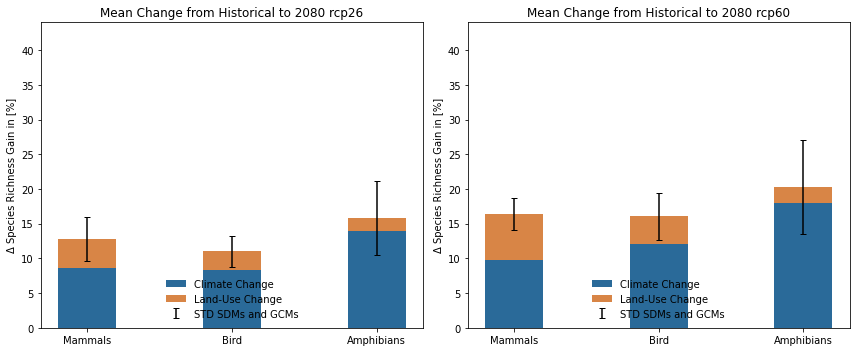

2.2448453795420793 18.038811162503386


In [89]:
# relative loss in species richness globally 
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}

    for sdm in sdms:
        mean_newvalue_change[scenario][sdm] = {}
        mean_sum_bin_change[scenario][sdm] = {}
        mean_land_use_change[scenario][sdm] = {}

        for gcm in gcms:
            mean_newvalue_change[scenario][sdm][gcm] = {}
            mean_sum_bin_change[scenario][sdm][gcm] = {}
            mean_land_use_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

                    
                # Calculate the relative difference using the non-zero mask
                # Where the mask is False, set the result to NaN to indicate these values should be excluded


                # Handle missing values (if necessary)
                da1_filled = newvalue_future_sum_taxa.fillna(0)  # Replace NaNs with 0
                da2_filled = newvalue_hist_sum_taxa.fillna(0)  # Replace NaNs with 0
                relative_difference = abs(da1_filled - da2_filled) / np.maximum(abs(da1_filled), abs(da2_filled))
                climate_change = relative_difference.fillna(0) * 100 # Replace NaNs from division by zero with 0
                
                
                # Handle missing values (if necessary)
                da1_filled = sum_bin_future_sum_taxa.fillna(0)  # Replace NaNs with 0
                da2_filled = sum_bin_hist_sum_taxa.fillna(0)  # Replace NaNs with 0

                                # Calculate the relative difference
                relative_difference = abs(da1_filled - da2_filled) / np.maximum(abs(da1_filled), abs(da2_filled))


                # Handle divisions by zero (if necessary)
                climate_land_change = relative_difference.fillna(0) * 100  # Replace NaNs from division by zero with 0


# Handle divisions by zero (if necessary)



                land_use_change = climate_land_change - climate_change
                
                

                                #climate_change_loss = climate_change.where(climate_change < 0)
                climate_land_change_gain = climate_land_change.where(climate_land_change>0)
                climate_change_gain = climate_change.where(climate_change > 0)
                
               # climate_change_gain = remove_outliers(climate_change_gain)
               # climate_land_change_gain = remove_outliers(climate_land_change_gain)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][sdm][gcm][taxa] = climate_change_gain
                mean_sum_bin_change[scenario][sdm][gcm][taxa] = climate_land_change_gain


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]

        mean_climate_change = np.nanmean([np.nanmean(mean_newvalue_change[scenario][sdm][gcm][taxa].values) for sdm in sdms for gcm in gcms])
        mean_land_use_change2 = np.nanmean([np.nanmean(mean_sum_bin_change[scenario][sdm][gcm][taxa].values - mean_newvalue_change[scenario][sdm][gcm][taxa].values) for sdm in sdms for gcm in gcms])

        std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()
print(mean_land_use_change2, mean_climate_change)

In [1]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM","GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    
                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue


                min_threshold = 1e-6  # Adjust this threshold based on your data


                newvalue_hist_sum_taxa_filtered = newvalue_hist_sum_taxa.where(newvalue_hist_sum_taxa > min_threshold, np.nan)
                difference = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa_filtered) / newvalue_hist_sum_taxa_filtered * 100
                climate_change = difference.where((difference >= -100) & (difference <= 100))
                
                climate_change = climate_change.where(non_zero_mask, np.nan)

                
                sum_bin_hist_sum_taxa_filtered = sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa > min_threshold, np.nan)
                difference = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa_filtered) / sum_bin_hist_sum_taxa_filtered * 100
                climate_land_change = difference.where((difference >= -100) & (difference <= 100))


                climate_land_change = climate_land_change.where(non_zero_mask, np.nan)

                
               # climate_land_change= climate_land_change * 100     
                climate_change_loss = climate_change.where(climate_change > 0)
                climate_land_change_loss = climate_land_change.where(climate_land_change>0)



                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_loss
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_loss
                
                gcm_data_newvalue.append(climate_change_loss)
                gcm_data_sum_bin.append(climate_land_change_loss)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        std_dev_climate_change = np.std([np.nanmean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Standard Deviation')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'Standard Deviation'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


NameError: name 'non_zero_mask' is not defined

/scratch/local/4428042/ipykernel_93326/2513819778.py:102: RuntimeWarning: invalid value encountered in subtract
  combined_data = mean_sum_bin_change[scenario][sdm][gcm][taxa].values - mean_newvalue_change[scenario][sdm][gcm][taxa].values
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:2229: RuntimeWarning: invalid value encountered in double_scalars
  dx = [convert(x0 + ddx) - x for ddx in dx]
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/matplotlib/transforms.py:2042: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty
/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..

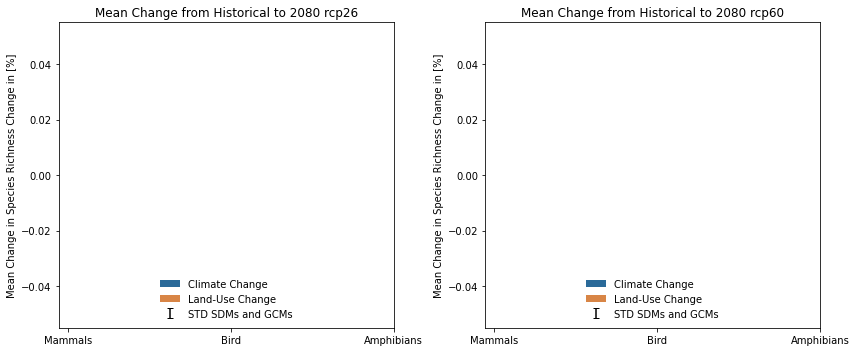

In [121]:
# relative change, no otliers  in species richness globally
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def remove_outliers(data):
    Q1 = np.nanpercentile(data, 25)
    Q3 = np.nanpercentile(data, 75)
    IQR = Q3 - Q1
    return data[(data >= Q1 - 1.5 * IQR) & (data <= Q3 + 1.5 * IQR)]


# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}

    for sdm in sdms:
        mean_newvalue_change[scenario][sdm] = {}
        mean_sum_bin_change[scenario][sdm] = {}
        mean_land_use_change[scenario][sdm] = {}

        for gcm in gcms:
            mean_newvalue_change[scenario][sdm][gcm] = {}
            mean_sum_bin_change[scenario][sdm][gcm] = {}
            mean_land_use_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

                    
                    
                                                    # Avoid division by zero

                
                climate_change = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / (newvalue_hist_sum_taxa) *100
                climate_land_change = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / (sum_bin_hist_sum_taxa) * 100
                land_use_change = climate_land_change - climate_change
                
                

                                #climate_change_loss = climate_change.where(climate_change < 0)
               # climate_land_change_gain = climate_land_change.where(climate_land_change>0)
               # climate_change_gain = climate_change.where(climate_change > 0)
                
               # climate_change_gain = remove_outliers(climate_change_gain)
               # climate_land_change_gain = remove_outliers(climate_land_change_gain)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][sdm][gcm][taxa] = climate_change
                mean_sum_bin_change[scenario][sdm][gcm][taxa] = climate_land_change


cleaned_means = {}

for scenario in scenarios:
    cleaned_means[scenario] = {}
    for sdm in sdms:
        cleaned_means[scenario][sdm] = {}
        for gcm in gcms:
            cleaned_means[scenario][sdm][gcm] = {}
            for taxa in taxas:
                # Combine the data
                combined_data = mean_sum_bin_change[scenario][sdm][gcm][taxa].values - mean_newvalue_change[scenario][sdm][gcm][taxa].values
                # Apply outlier removal
                cleaned_data = remove_outliers(combined_data)
                # Calculate the mean
                cleaned_means[scenario][sdm][gcm][taxa] = np.nanmean(cleaned_data)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        # ...
        mean_climate_change = np.mean([np.nanmean(mean_newvalue_change[scenario][sdm][gcm][taxa].values) for sdm in sdms for gcm in gcms])
        mean_land_use_change2 = np.mean([cleaned_means[scenario][sdm][gcm][taxa] for sdm in sdms for gcm in gcms])
        

        std_dev_climate_change = np.std([np.nanmean(remove_outliers(mean_newvalue_change[scenario][sdm][gcm][taxa].values)) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('Mean Change in Species Richness Change in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


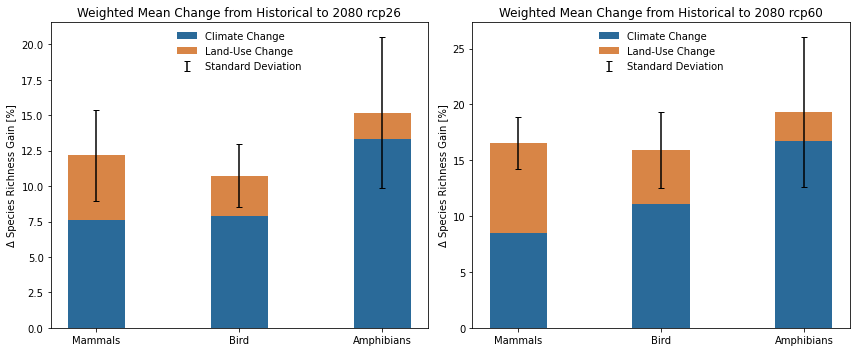

In [79]:
#weighted mean but turn around where we do it 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants


# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)


                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue
                
                # Handle missing values (if necessary)
                da1_filled = newvalue_future_sum_taxa.fillna(0)  # Replace NaNs with 0
                da2_filled = newvalue_hist_sum_taxa.fillna(0)  # Replace NaNs with 0

                                # Calculate the relative difference
                relative_difference = abs(da1_filled - da2_filled) / np.maximum(abs(da1_filled), abs(da2_filled))


                # Handle divisions by zero (if necessary)
                climate_change = relative_difference.fillna(0) * 100 # Replace NaNs from division by zero with 0
                
                
                # Handle missing values (if necessary)
                da1_filled = sum_bin_future_sum_taxa.fillna(0)  # Replace NaNs with 0
                da2_filled = sum_bin_hist_sum_taxa.fillna(0)  # Replace NaNs with 0

                                # Calculate the relative difference
                relative_difference = abs(da1_filled - da2_filled) / np.maximum(abs(da1_filled), abs(da2_filled))


                # Handle divisions by zero (if necessary)
                climate_land_change = relative_difference.fillna(0) * 100  # Replace NaNs from division by zero with 0


# Handle divisions by zero (if necessary)



                land_use_change = climate_land_change - climate_change
                
                

                                #climate_change_loss = climate_change.where(climate_change < 0)
                climate_land_change_gain = climate_land_change.where(climate_land_change>0)
                climate_change_gain = climate_change.where(climate_change > 0)
                
               # climate_change_gain = remove_outliers(climate_change_gain)
               # climate_land_change_gain = remove_outliers(climate_land_change_gain)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_gain
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_gain
                
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"
                
                interpolated_data = newvalue_future_sum_taxa.interp(lat=grid_cells.lat, lon=grid_cells.lon)

                # Now we can calculate the weights using the interpolated latitude values
                weights = np.cos(np.deg2rad(interpolated_data.lat))

                cell_area_xr = weights_newvalue


                # Calculate weighted mean for each GCM
                air_weighted_gcm = climate_change_gain.weighted(cell_area_xr)
                weighted_mean_gcm = air_weighted_gcm.mean(("lon", "lat"))
                gcm_data_newvalue.append(weighted_mean_gcm)

                # Repeat for sum_bin data
                air_weighted_gcm = climate_land_change_gain.weighted(cell_area_xr)
                weighted_mean_gcm = air_weighted_gcm.mean(("lon", "lat"))
                gcm_data_sum_bin.append(weighted_mean_gcm)

            # Calculate weighted mean across GCMs
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.mean(dim="gcm")

            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.mean(dim="gcm")

            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Calculate weighted mean across SDMs
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')


        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=["sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["sdm"])

                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        

        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = (final_weighted_mean_sum_bin_change[scenario][taxa]-final_weighted_mean_newvalue_change[scenario][taxa]).mean().values
        std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])
        
        
        
        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Standard Deviation')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'Standard Deviation'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
   # ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='upper center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


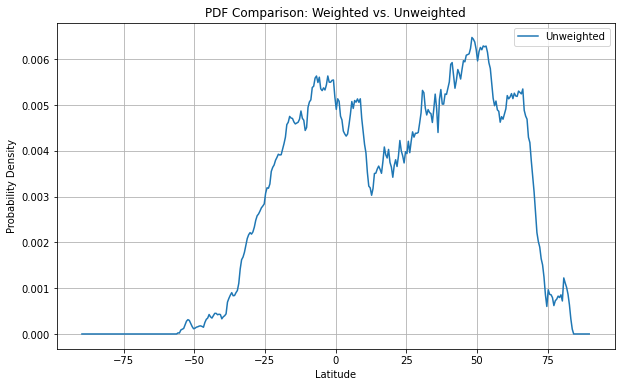

In [75]:
# Assuming 'newvalue_future_sum_taxa' has the actual data values we need to use
# We can directly use it to calculate the weights and the PDFs

# Calculate weights as the cosine of the latitude in radians
# Note: 'newvalue_future_sum_taxa.lat' should be used directly since it matches the data's grid
weights = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))

# Apply the weights to the DataArray to get weighted grid cells
weighted_grid_cells = newvalue_future_sum_taxa.weighted(weights)



# To create a PDF, we'll sum across the longitude to get the total value for each latitude
pdf_weighted = mean_climate_change
pdf_unweighted = newvalue_future_sum_taxa.sum(dim='lon')

# Normalize the PDFs to have a sum of 1
pdf_weighted /= pdf_weighted.sum()
pdf_unweighted /= pdf_unweighted.sum()

# Plot the PDFs for comparison
plt.figure(figsize=(10, 6))
plt.plot(newvalue_future_sum_taxa.lat, pdf_unweighted, label='Unweighted')
plt.xlabel('Latitude')
plt.ylabel('Probability Density')
plt.title('PDF Comparison: Weighted vs. Unweighted')
plt.legend()
plt.grid()
plt.show()


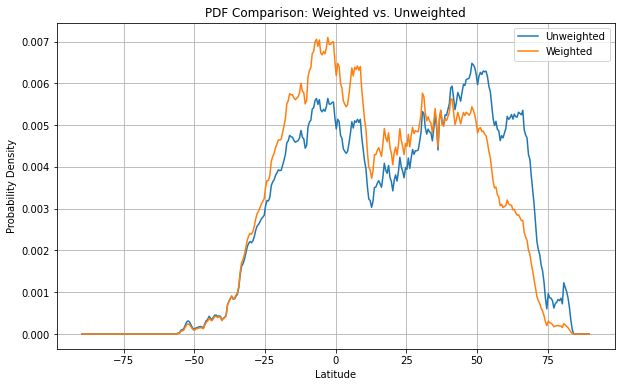

In [57]:
# Assuming 'newvalue_future_sum_taxa' has the actual data values we need to use
# We can directly use it to calculate the weights and the PDFs

# Calculate weights as the cosine of the latitude in radians
# Note: 'newvalue_future_sum_taxa.lat' should be used directly since it matches the data's grid
weights = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))

# Apply the weights to the DataArray to get weighted grid cells
weighted_grid_cells = newvalue_future_sum_taxa.weighted(weights)



# To create a PDF, we'll sum across the longitude to get the total value for each latitude
pdf_weighted = weighted_grid_cells.sum(dim='lon')
pdf_unweighted = newvalue_future_sum_taxa.sum(dim='lon')

# Normalize the PDFs to have a sum of 1
pdf_weighted /= pdf_weighted.sum()
pdf_unweighted /= pdf_unweighted.sum()

# Plot the PDFs for comparison
plt.figure(figsize=(10, 6))
plt.plot(newvalue_future_sum_taxa.lat, pdf_unweighted, label='Unweighted')
plt.plot(newvalue_future_sum_taxa.lat, pdf_weighted, label='Weighted')
plt.xlabel('Latitude')
plt.ylabel('Probability Density')
plt.title('PDF Comparison: Weighted vs. Unweighted')
plt.legend()
plt.grid()
plt.show()


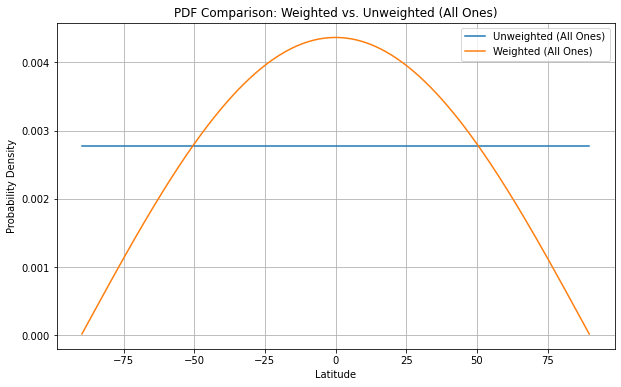

In [59]:
# Recreating the 'newvalue_future_sum_taxa' as before, but this time each grid cell will have the value 1
lat_values_highres = np.linspace(89.75, -89.75, 360)
lon_values_highres = np.linspace(-179.8, 179.8, 720)
data_ones = np.ones((len(lat_values_highres), len(lon_values_highres)))  # Each grid cell has the value 1

# Create a DataArray for the fake data
fake_data_array = xr.DataArray(data_ones, coords={'lat': lat_values_highres, 'lon': lon_values_highres}, dims=('lat', 'lon'))


# Apply the weights to the DataArray to get weighted grid cells
weighted_fake_data = fake_data_array.weighted(weights)

# To create a PDF, we'll sum across the longitude to get the total value for each latitude
pdf_weighted_fake = weighted_fake_data.sum(dim='lon')
pdf_unweighted_fake = fake_data_array.sum(dim='lon')

# Normalize the PDFs to have a sum of 1
pdf_weighted_fake /= pdf_weighted_fake.sum()
pdf_unweighted_fake /= pdf_unweighted_fake.sum()

# Plot the PDFs for comparison
plt.figure(figsize=(10, 6))
plt.plot(fake_data_array.lat, pdf_unweighted_fake, label='Unweighted (All Ones)')
plt.plot(fake_data_array.lat, pdf_weighted_fake, label='Weighted (All Ones)')
plt.xlabel('Latitude')
plt.ylabel('Probability Density')
plt.title('PDF Comparison: Weighted vs. Unweighted (All Ones)')
plt.legend()
plt.grid()
plt.show()


In [50]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Let's assume newvalue_future_sum_taxa is already loaded as an xarray.DataArray

# Step 1: Verify the data
data_values = newvalue_future_sum_taxa.values
if np.all(data_values == 0):
    print("Data check: The data array contains only zeros.")
else:
    print("Data check: The data array contains non-zero values.")

# Step 2: Check latitude values
lat_values = newvalue_future_sum_taxa.lat.values
if not np.all((-90 <= lat_values) & (lat_values <= 90)):
    print("Latitude check: Latitude values are out of bounds.")
else:
    print("Latitude check: Latitude values are within the correct range.")

# Step 3: Weights calculation
weights = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
if np.any(np.isnan(weights)):
    print("Weights calculation: NaN values found in weights.")
else:
    print("Weights calculation: Weights calculated successfully without NaN values.")

# Step 4: PDF calculation and


Data check: The data array contains non-zero values.
Latitude check: Latitude values are within the correct range.
Weights calculation: Weights calculated successfully without NaN values.


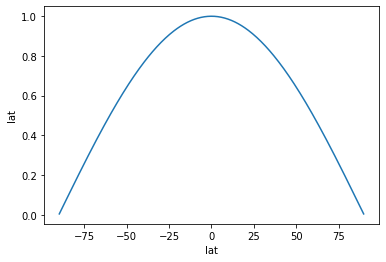

In [58]:
weights.plot()

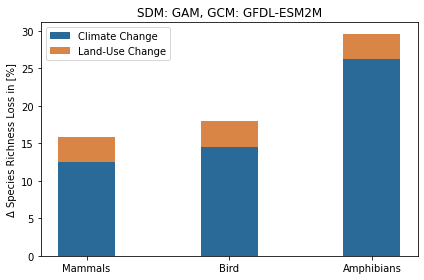

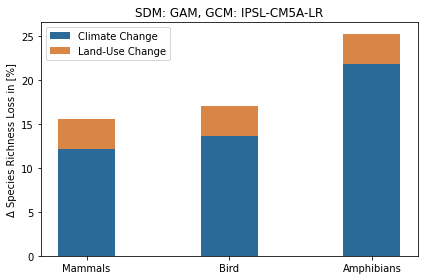

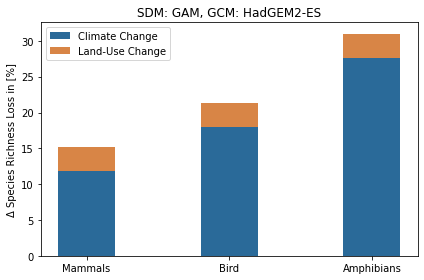

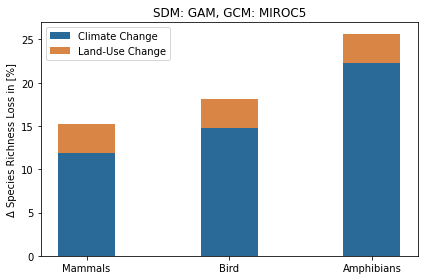

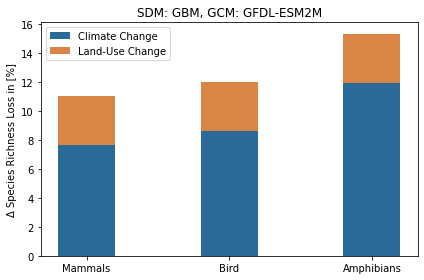

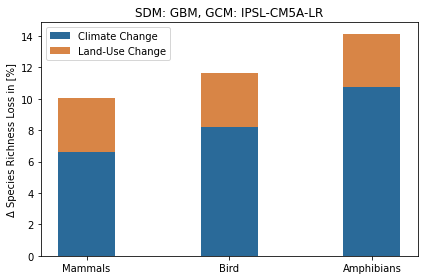

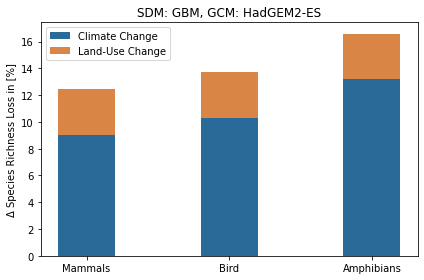

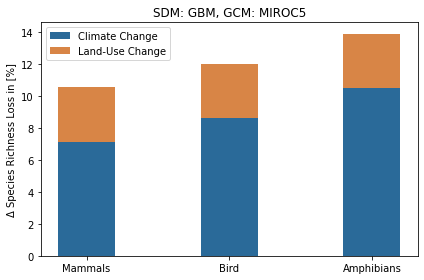

In [91]:

# Create separate plots for each combination of SDM and GCM
for sdm in sdms:
    for gcm in gcms:
        # Set up the bar plot
        fig, ax = plt.subplots()

        color_change = "#2a6a99"
        color_land_use_change = "#d88546"

        bar_width = 0.4
        error_bar_shift = 0.1

        x_positions = np.arange(len(taxas))

        # Create a variable to store the handles and labels for the legend
        handles, labels = [], []

        for i, taxa in enumerate(taxas):
            x_shift = x_positions[i]

            # Calculate the mean values for the specific combination of SDM and GCM
            mean_climate_change = np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa])
            mean_land_use_change = np.mean(mean_sum_bin_change[scenario][sdm][gcm][taxa] - mean_newvalue_change[scenario][sdm][gcm][taxa])

            # Calculate standard deviation or confidence interval for climate_change


            if not i:
                handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
                handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')

            else:
                ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
                ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)


        # Combine handles and labels for legend
        handles.extend([handle_climate_change, handle_land_use_change])
        labels.extend(['Climate Change', 'Land-Use Change', 'Uncertainty'])

        # Set plot details
        ax.set_xticks(x_positions)
        ax.set_xticklabels(taxas)
        ax.set_ylabel('\u0394 Species Richness Loss in [%]')
        ax.legend(handles=handles, labels=labels)

        # Set plot title with the combination of SDM and GCM
        ax.set_title(f"SDM: {sdm}, GCM: {gcm}")

        plt.tight_layout()
        plt.show()
